The representations learned by convnets are highly amenable to visualization, in large part because they’re *representations of visual concepts*. We’ll cover three of the most accessible and useful techniques for visualizing and interpreting these representations.

- **Visualizing intermediate convnet outputs (intermediate activations):** Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.
- **Visualizing convnets filters:** Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
- **Visualizing heatmaps of class activation in an image:** Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.

For the first method—*activation visualization*—we’ll use the small convnet that we trained from scratch on the dogs-versus-cats classification problem in section 5.2. For the next two methods, we’ll use the VGG16 model introduced in section 5.3.

# Visualizing intermediate activations
Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its *activation*, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network.

You want to visualize feature maps with three dimensions: width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary() # Reminder of this model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [2]:
img_path = '/home/gary/Downloads/train/cat.1700.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


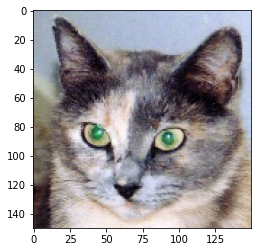

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In order to extract the feature maps you want to look at, you’ll create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, you’ll use the Keras class `Model`. A model is instantiated using two arguments: an input tensor (or list of input tensors) and an output tensor (or list of output tensors).

What sets the `Model` class apart is that it allows for models with multiple outputs, unlike `Sequential`. 

In [4]:
from tensorflow.keras import models

# Extracts the outputs of the top eight layers
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

When fed an image input, this model returns the values of the layer activations in the original model. This is the first time we’ve encountered a multi-output model in this book: until now, the models we’ve seen have had exactly one input and one output. In the general case, a model can have any number of inputs and outputs. This one has
one input and eight outputs: one output per layer activation.

In [5]:
# Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(img_tensor)

For instance, the activation of the first convolution layer for the cat image input is a 148 × 148 feature map with 32 channels.

In [6]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


Let’s try plotting the **ninth channel** of the activation of the first layer of the original model

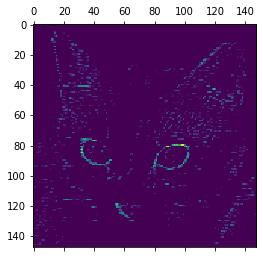

In [7]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 8], cmap='viridis')

This channel appears to encode a diagonal edge detector.

Let’s try another channel—but note that your own channels may vary, because the specific filters learned by convolution layers aren’t deterministic.

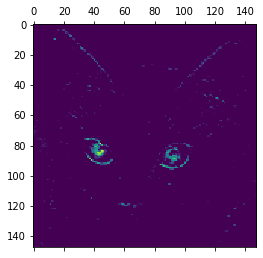

In [8]:
plt.matshow(first_layer_activation[0, :, :, 12], cmap='viridis')

This one looks like a “bright green dot” detector, useful to encode cat eyes.

At this point, let’s plot a complete visualization of all the activations in the network.  
You’ll extract and plot every channel in each of the eight activation maps,  
and you’ll stack the results in one big image tensor, with channels stacked side by side.

<ipython-input-9-63de1860a871>:27: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


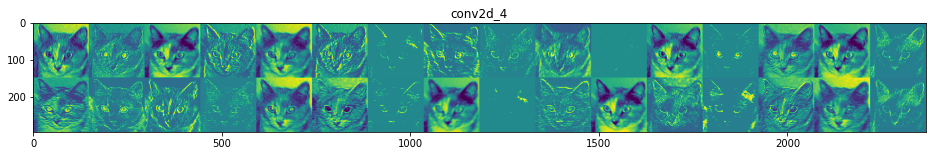

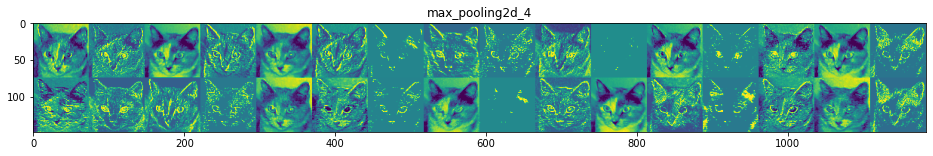

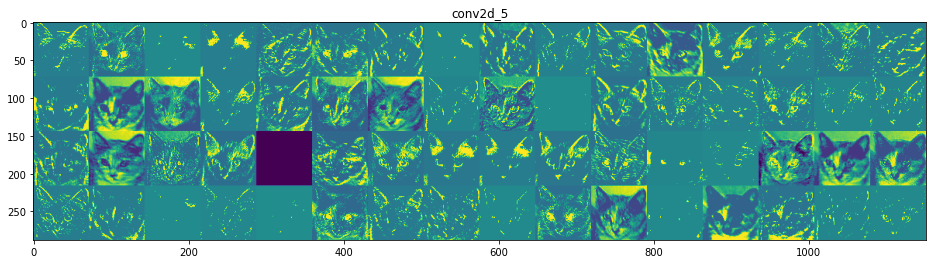

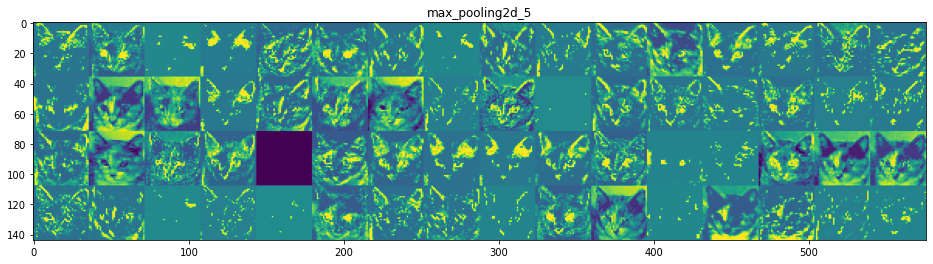

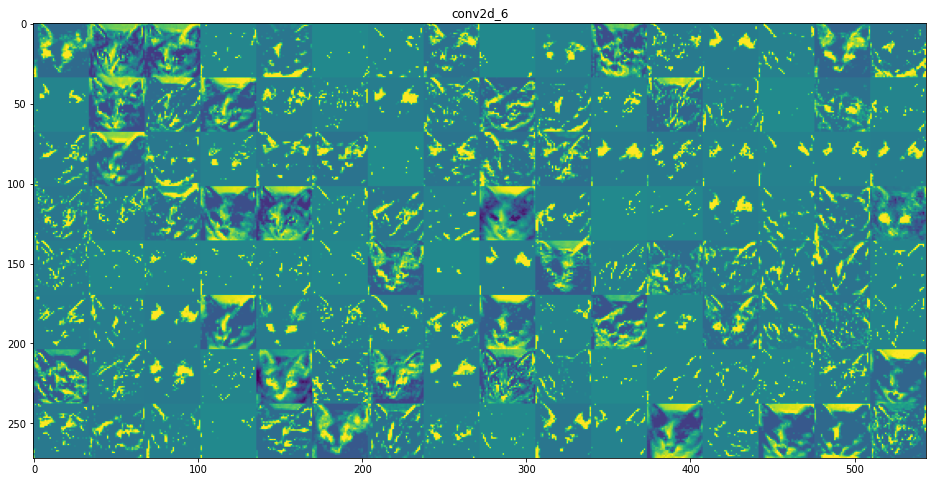

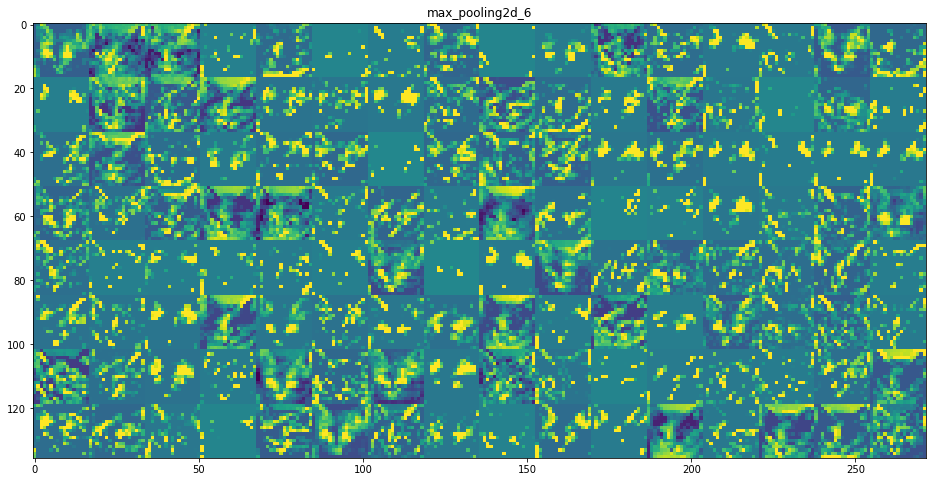

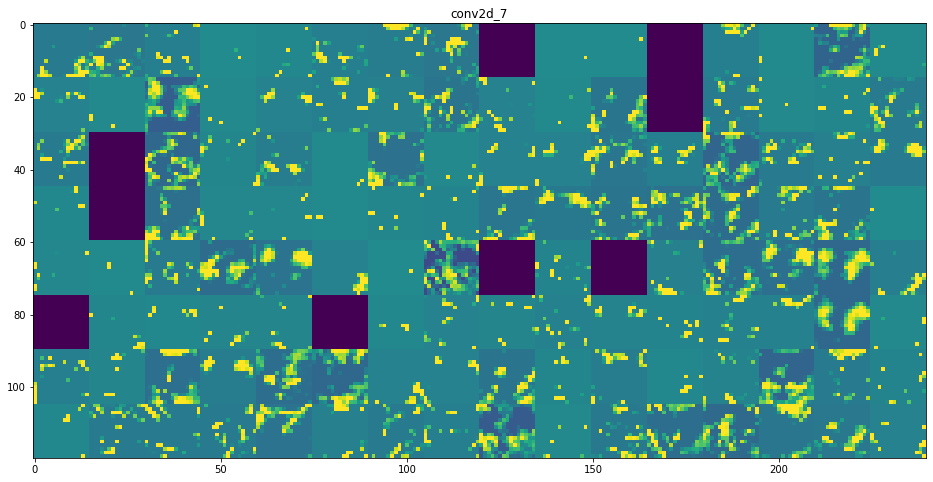

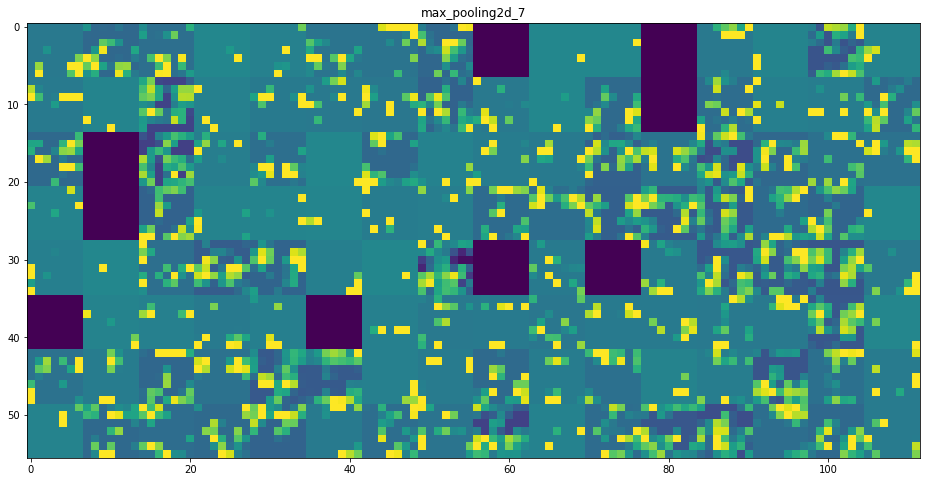

In [9]:
layer_names = []
# Add names so we can have them in the plot
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Display the feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # Number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features).
    size = layer_activation.shape[1]
    
    # Tiles the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Tiles each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            
            # Post-processes the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            # Display the grid
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

There are a few things to note here:
- The first layer acts as a collection of various edge detectors. *At that stage, the activations retain almost all of the information present in the initial picture*.
- As you go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” **Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image.**
- **The sparsity of the activations increases with the depth of the layer**: in the first layer, all filters are activated by the input image; but in the following layers, more and more filters are blank. *This means the pattern encoded by the filter isn’t found in the input image*.

We have just evidenced an important universal characteristic of the representations learned by deep neural networks: the features extracted by a layer become increasingly abstract with the depth of the layer. A deep neural network effectively acts as an *information distillation pipeline*, with raw data going in and being repeatedly transformed so that irrelevant information is filtered out (for example, the specific visual appearance of the image), and useful information is magnified and refined (for example, the class of the image).

This is analogous to the way humans and animals perceive the world: after observing a scene for a few seconds, a human can remember which abstract objects were present in it (bicycle, tree) but can’t remember the specific appearance of these objects.

# Visualizing convnet filters
Another easy way to inspect the filters learned by convnets is to **display the visual pattern that each filter is meant to respond to**. This can be done with *gradient ascent in input space*: **applying *gradient descent* to the value of the input image of a convnet so as to *maximize* the response of a specific filter, starting from a blank input image**. The resulting input image will be one that the chosen filter is maximally responsive to.

The process is simple: you’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then you’ll use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. For instance, here’s a loss for the activation of filter 0 in the layer `block3_conv1` of the VGG16 network, pretrained on ImageNet.


In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

img_width = 150
img_height = 150

layer_name = 'block3_conv1'

# Deprecated
##layer_output = model.get_layer(layer_name).output
##loss = K.mean(layer_output[:, :, :, filter_index])

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

To implement gradient ascent, we’ll need the gradient of this loss with respect to the model’s input. To do this, ~~we’ll use the `gradients` function packaged with the `backend` module of Keras.~~ we'll need to write a function that computes the loss and another function that computes the gradients of the loss.

The following code was taken from [an article](https://keras.io/examples/vision/visualizing_what_convnets_learn/), which was helpful in demonstrating the proper way to use `tf.GradientTape()` for this case as the methods provided in the text was deprecated.

In [11]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

Our gradient ascent function simply computes the gradients of the loss above with regard to the input image, and update the update image so as to move it towards a state that will activate the target filter more strongly.

In [12]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

#### Set up the end-to-end filter visualization loop

Our process is as follow:

- Start from a random image that is close to "all gray" (i.e. visually netural)
- Repeatedly apply the gradient ascent step function defined above
- Convert the resulting input image back to a displayable form, by normalizing it, center-cropping it, and restricting it to the [0, 255] range.

In [13]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # Our model expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

Let's try it out with filter 0 in the target layer:

In [14]:
from IPython.display import Image, display

loss, img = visualize_filter(0)
keras.preprocessing.image.save_img("0.png", img)

This is what an input that maximizes the response of filter 0 in the target layer would look like:

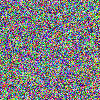

In [15]:
display(Image("0.png"))

It seems that filter 0 in layer `block3_conv1` is responsive to a static pattern. Now the fun part: you can start visualizing every filter in every layer. Let's make a 8x8 grid of the first 64 filters in the target layer to get of feel for the range of different visual patterns that the model has learned.

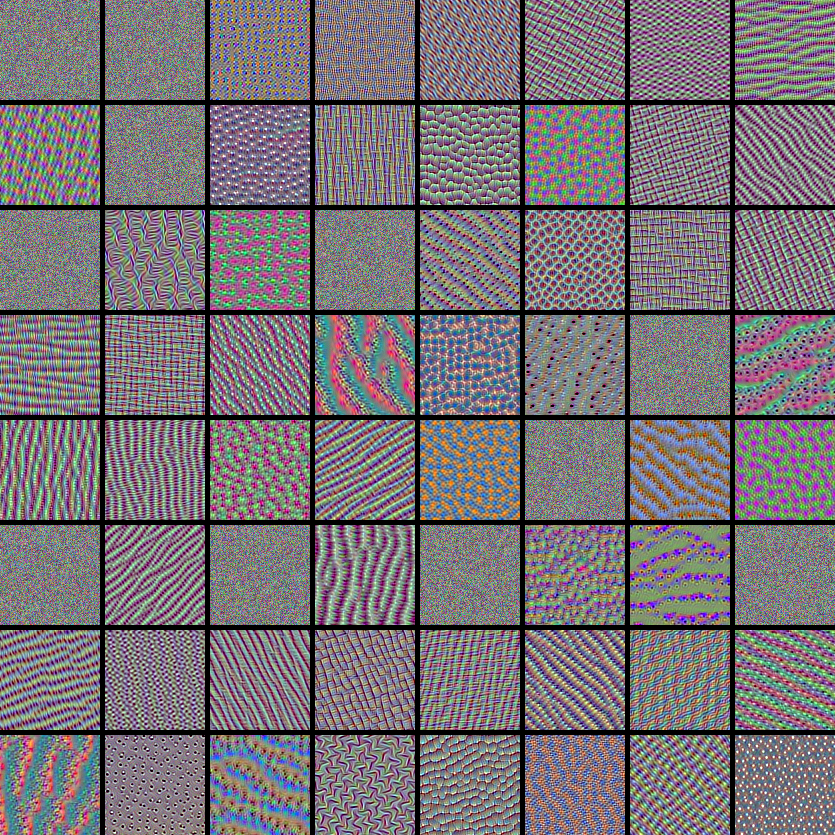

In [16]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img

keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

display(Image("stiched_filters.png"))

Image classification models see the world by decomposing their inputs over a "vector basis" of texture filters such as these.

## Visualizing heatmaps of class activation
We’ll introduce one more visualization technique: one that is useful for understanding which parts of a given image led a convnet to its final classification decision. This is helpful for debugging the decision process of a convnet, particularly in the case of a classification mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called **class activation map** (CAM) visualization, and it consists of producing heatmaps of class activation over input images. A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration. 

For instance, given an image fed into a dogs-versus-cats convnet, **CAM visualization allows you to generate a heatmap for the class “cat,” indicating how cat-like different parts of the image are, and also a heatmap for the class “dog,” indicating how dog-like parts of the image are.**

The specific implementation you’ll use is the one described in “Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization.” It’s very simple: it consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel.

Intuitively, one way to understand this trick is that you’re weighting a spatial map of “how intensely the input image activates different channels” by “how important each channel is with regard to the class,” resulting in a spatial map of “how intensely the input image activates the class.”

We’ll demonstrate this technique using the pretrained VGG16 network again.

Note: The techniques below derive from a similar [article](https://keras.io/examples/vision/grad_cam/), as the methods in the book are deprecated.

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16

# Note that you include the densely connected classifier on top;
# in all previous cases, you discarded it.

model = VGG16(weights='imagenet')

In [18]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

img_path = '/home/gary/Downloads/elephants.jpg'

# this model was trained on images of size 224 × 244
# we will resize it when we load the image
img_size = (224,224)

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array

img_array = preprocess_input(get_img_array(img_path, size=img_size))

Before moving on, let's have a look at the image so we can see it for ourselves.

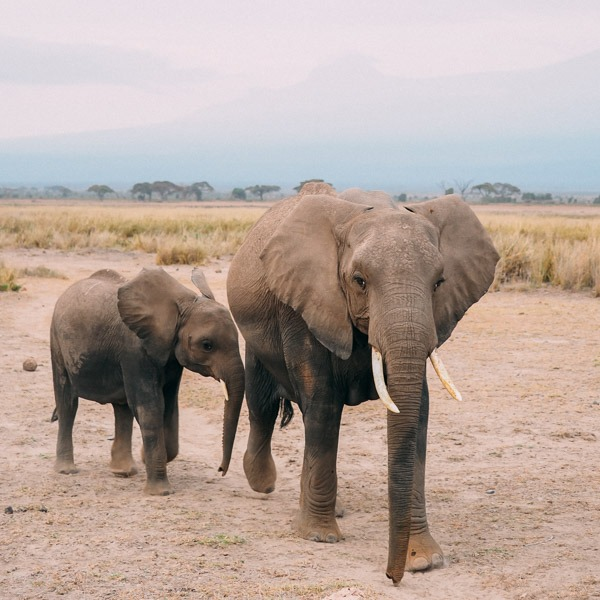

In [19]:
display(Image(img_path))

We can now run the pretrained network on the image and decode its prediction vector back to a human-readable format:

In [20]:
preds = model.predict(img_array)

In [21]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.82344097), ('n02504013', 'Indian_elephant', 0.09473983), ('n01871265', 'tusker', 0.08153543)]


The top three classes predicted for this image are as follows:
- African elephant (with 82.3% probability)
- Indian elephant (with 9.7% probability)
- Tusker (with 8% probability)

The network has recognized the image as containing an undetermined quantity of African elephants. The entry in the prediction vector that was maximally activated is the one corresponding to the “African elephant” class, at index 386, which we know from the `argmax` of `preds[0]`:

In [22]:
np.argmax(preds[0])

386

To visualize which parts of the image are the most African elephant–like, let’s set up the Grad-CAM process.

In [23]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

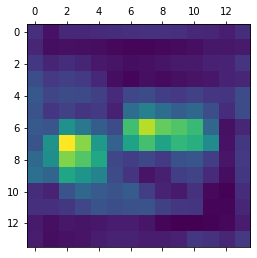

In [24]:
# Output feature map of the block5_conv3 layer,
# the last convolutional layer in VGG16
last_conv_layer_name = 'block5_conv3'

# Remove last layer's softmax
model.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

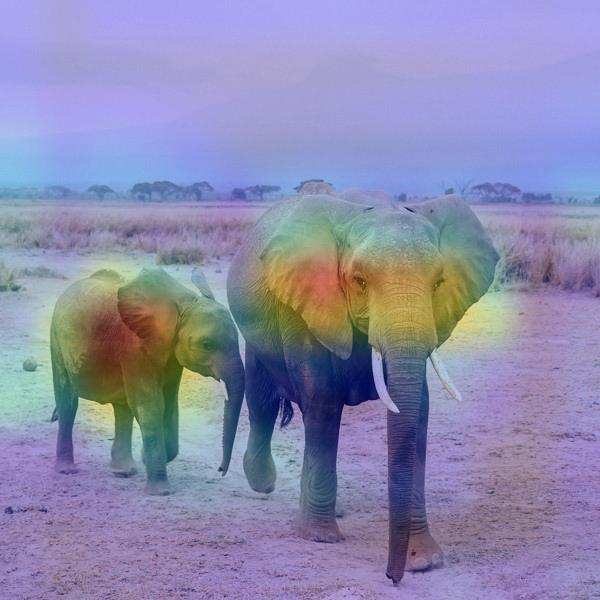

In [25]:
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

This visualization technique answers two important questions:
- Why did the network think this image contained an African elephant?
- Where is the African elephant located in the picture?

In particular, it’s interesting to note that the ears of the more adult elephant are strongly activated: this is probably how the network can tell the difference between African and Indian elephants.

## Let's try another image
We will see how the grad cam explains the model's outputs for a multi-label image. Let's try an image with a cat and a dog together, and see how the grad cam behaves.

Note that we haven't learned about the model used in this example.  
We will use it for fun, as the VGG16 model does not perform as well with the mutiple class identification image below.

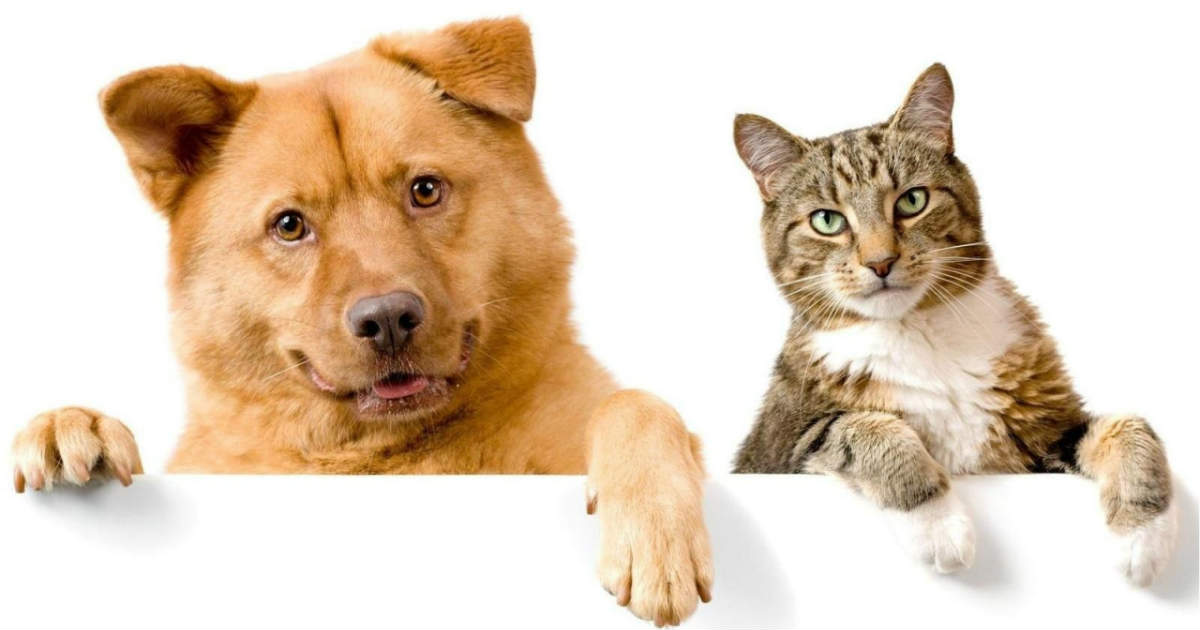

Predicted: [('n02112137', 'chow', 4.611239), ('n02124075', 'Egyptian_cat', 4.3817377)]


In [26]:
model_builder = keras.applications.xception.Xception
model = model_builder(weights="imagenet")

img_size = (299, 299)

preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

# Remove last layer's softmax
model.layers[-1].activation = None

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

In [27]:
np.argpartition(preds[0], -2)[-2:]

array([285, 260])

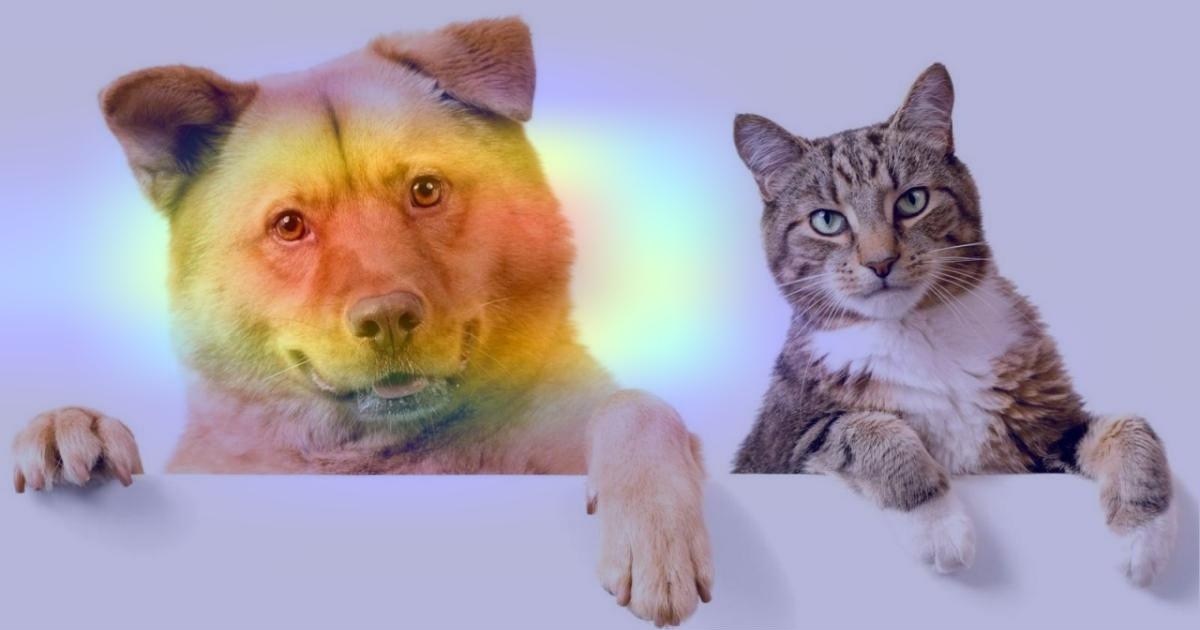

In [28]:
# Chow pred_index=260
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

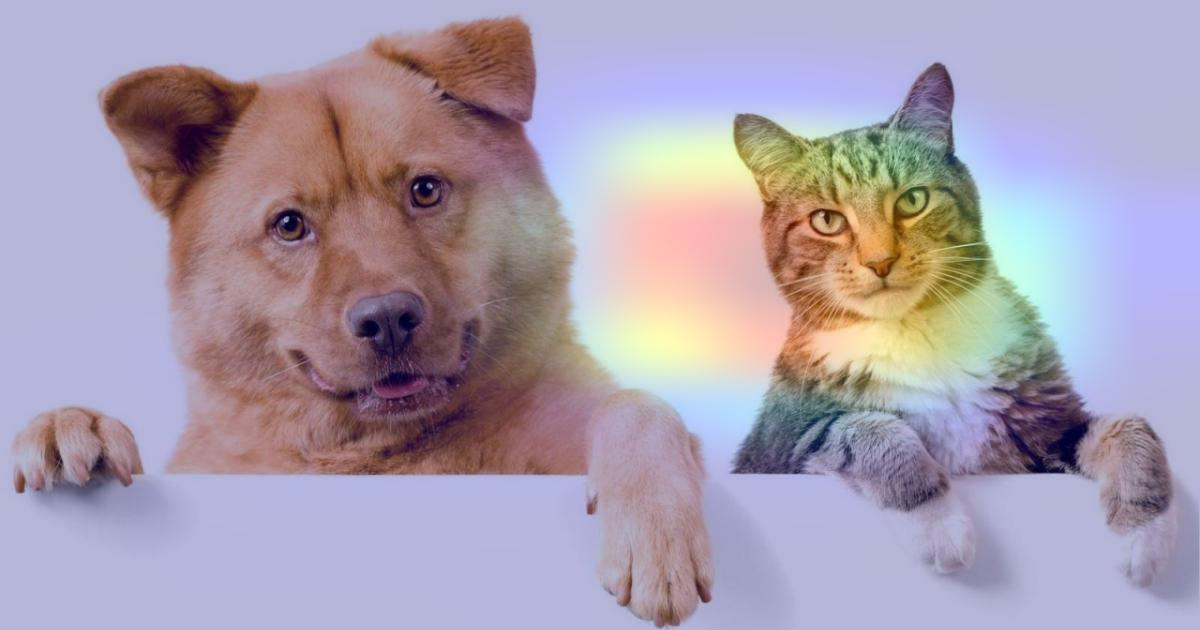

In [29]:
# Egyptian_cat pred_index=285
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)